In [167]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy  --upgrade --quiet
# !pip3 install scipy --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quiet
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade  --quiet
# !pip install scikit-optimize  --quiet
# !pip install -U --quiet yellowbrick
# !pip install apafib --upgrade  --quiet
# !pip install --upgrade pip
# !pip install ucimlrepo

In [168]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
import matplotlib.dates as mdates

from apafib import load_dormir
from scipy import stats
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy


import warnings
warnings.filterwarnings('ignore')

# Definiciones
RND = 16
MAX_ITER = 5000

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                
    else:
        mant = p / (10.0**exp)
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    
# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

init_time = time()

# Práctica de APA. Preprocesado de las variables.

## Introducción

Autores: Oriol Farrés y Marc Gil

Al tratarse de un problema de series temporales y disponer de los datos íntegramente de los años 2011 a 2024, dividiremos de la siguiente manera:

* Train Set: Años 2011 a 2020 (10 años)
* Test Set: Años 2021 a 2024 (4 años)

Es decir un ratio de ~71.5% para el conjunto de entrenamiento y un ~28.5% para el conjunto de test.

---

Al tener tal cantidad de trabajo con el preprocesado de las variables para el problema, para asegurarnos de que hay consistencia y evitar cometer errores metodológicos, seguiremos la siguiente estructura (basada en la lista propuesta en el LAB y en el guión de la práctica): 




**Fase A: Obtención de los datos**

1. Preámbulo

**Fase B: Limpieza de los datos**

1. Preparar las variables (Sanity Check)
2. Tratamiento de valores incoherentes o incorrectos
3. Tratamiento de missing values
4. Tratamiento de outliers
5. Crear nuevas variables que pueden ser interesantes (Feature engineering)
6. Re-nombrado de las variables
7. Eliminar data leakage

**Fase C: Separación de los datos**

1. División del dataset en train/test 

**Fase D: Análisis**

1. Exploratorio Mínimo

**Fase E: Preprocesado de  las variables**

1. Dividir dataset en X e y
2. Transformar categóricas con OHE y escalar numéricas
3. Aplicar cambios 

**Fase F: Reducción de la dimensionalidad y visualización**

1. Aplicar PCA
2. Aplicar t-SNE
3. Comentarios sobre la reducción de dimensionalidad  

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase A-Obtención de los datos

## A.1-Preámbulo

> Tenemos todo el dataset preparado en el directorio data/raw/raw_atp_matches.csv.

In [169]:
tennis = pd.read_csv('./data/raw/raw_atp_matches.csv')
tennis.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,month,day,month_name,tourney_points
0,2011-339,Brisbane,Hard,32,A,20110102,1,104417,1.0,NaN,...,4.0,5.0,5580.0,173.0,309.0,2011,1,2,January,250
1,2011-339,Brisbane,Hard,32,A,20110102,2,103582,NaN,NaN,...,5.0,58.0,835.0,75.0,643.0,2011,1,2,January,250
2,2011-339,Brisbane,Hard,32,A,20110102,3,105051,NaN,Q,...,8.0,196.0,263.0,204.0,243.0,2011,1,2,January,250
3,2011-339,Brisbane,Hard,32,A,20110102,4,104797,8.0,NaN,...,3.0,40.0,1031.0,43.0,975.0,2011,1,2,January,250
4,2011-339,Brisbane,Hard,32,A,20110102,5,103888,4.0,NaN,...,6.0,16.0,1991.0,83.0,600.0,2011,1,2,January,250


In [170]:
tennis.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tourney_id,39541,1894,2011-580,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_name,39541,1078,Roland Garros,1778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surface,39488,4,Hard,23060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draw_size,39541.0,NaN,NaN,NaN,57.467489,42.144138,2.0,32.0,32.0,96.0,128.0
tourney_level,39541,6,A,21148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_date,39541.0,NaN,NaN,NaN,20174404.064313,41143.884302,20110102.0,20140319.0,20170731.0,20210726.0,20241218.0
match_num,39541.0,NaN,NaN,NaN,167.239802,151.260611,1.0,21.0,190.0,283.0,1701.0
winner_id,39541.0,NaN,NaN,NaN,117737.747477,29694.476989,100644.0,104607.0,105373.0,109739.0,212721.0
winner_seed,16884.0,NaN,NaN,NaN,7.543592,6.988957,1.0,3.0,5.0,9.0,33.0
winner_entry,5347,10,Q,2968,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B-Limpieza de los datos

Antes de empezar con la limpieza, vamos a ver cuantas filas tenemos en el dataset, para asegurarnos de que no cometemos ningún error.

In [171]:
print(f"Nuestro dataset tiene {tennis.shape[1]} variables y {tennis.shape[0]:,} columnas.")

Nuestro dataset tiene 54 variables y 39,541 columnas.


## B.1-Preparar las variables (Sanity Check)

En este apartado, vamos a preparnos las variables para poder tratarlas correctamente en los siguientes pasos. Un primer paso es eliminar aquellos partidos donde el rival se ha retirado/no se ha presentado, ya que esto es, obviamente impredecible (almenos con nuestros datos), y solo confundiría al modelo.

### B.1-Paso 1. Eliminar partidos inválidos

In [172]:
tennis['score'].head()

0           6-2 6-4
1    1-6 7-6(3) 6-2
2       4-6 6-2 6-4
3        7-6(5) 6-4
4           6-1 6-4
Name: score, dtype: object

In [173]:
# 1. Ver los 20 resultados más comunes (para ver lo "normal")
print("Lo normal:")
print(tennis['score'].value_counts().head(10))

print("\n----------------\n")

# 2. TRUCO PRO: Buscar solo los scores que contienen letras
# Esto te mostrará de golpe todos los RET, W/O, Def, etc.
scores_con_letras = tennis[tennis['score'].str.contains('[a-zA-Z]', na=False)]['score']

print("Lo sospechoso (contiene letras):")
print(scores_con_letras.unique())

Lo normal:
score
6-3 6-4    1355
6-4 6-4    1330
6-3 6-2     849
6-4 6-3     803
6-4 6-2     787
6-3 6-3     728
6-2 6-4     632
6-2 6-2     548
6-2 6-3     499
6-1 6-4     432
Name: count, dtype: int64

----------------

Lo sospechoso (contiene letras):
['6-2 RET' '6-0 5-0 RET' '6-3 6-1 4-2 RET' '6-1 6-0 2-0 RET'
 '6-7(5) 6-2 6-1 4-3 RET' 'W/O' '5-2 RET' '6-2 1-0 RET' '6-1 0-1 RET'
 '3-6 6-5 RET' '4-0 RET' '6-1 2-0 RET' '5-0 RET' '6-7(5) 6-2 4-2 RET'
 '4-5 RET' '6-2 4-1 RET' '6-4 RET' '7-5 2-0 RET' '5-4 RET' '6-1 5-3 RET'
 '6-4 3-1 RET' '3-0 RET' '3-4 RET' '3-6 2-1 RET' '4-6 6-1 2-0 RET'
 '2-6 4-2 RET' '5-1 RET' '6-3 4-0 RET' '4-6 6-1 4-4 RET'
 '7-6(6) 3-6 5-2 RET' '6-2 3-0 RET' '6-7(5) 6-3 3-0 RET' '6-4 1-0 RET'
 '7-6(1) 1-0 RET' '6-2 2-0 RET' '4-6 6-3 6-2 3-1 RET' '6-4 6-1 2-3 RET'
 '4-3 RET' '6-4 6-6 RET' '7-6(5) 2-0 RET' '6-7(4) 6-4 3-0 RET'
 '7-6(5) 3-6 5-3 RET' '7-5 3-1 RET' '6-3 6-3 RET' '6-4 4-2 RET' '2-3 RET'
 '6-3 6-7(5) 6-2 1-1 RET' '6-7 6-3 6-1 RET' '2-6 6-2 6-3 2-0 RET'
 

In [174]:
# 1. Copia de seguridad inicial (opcional, pero recomendada)
print(f"Total partidos antes de limpiar score: {len(tennis)}")

# 2. Asegurar que la columna sea tipo string (texto) para que no falle el filtro
tennis['score'] = tennis['score'].astype(str)

# 3. Crear el filtro de "Marcadores Sucios"
# Buscamos: 'W/O' (No presentado), 'RET' (Retirado), 'Def' (Descalificado)
# case=False detecta tanto 'Ret' como 'RET'
filtro_score_sucio = tennis['score'].str.contains('W/O|RET|Def|Walkover|Aban|ABD', case=False, na=False)

# 4. Ver qué vamos a eliminar (para que te quedes tranquilo)
print("\nEjemplos de scores que vamos a ELIMINAR:")
print(tennis[filtro_score_sucio]['score'].unique()[:10]) # Mostramos los 10 primeros tipos

# 5. Aplicar el borrado
# El símbolo '~' significa "Quédate con lo que NO es sucio"
tennis = tennis[~filtro_score_sucio].copy()

# 6. Resetear el índice
tennis.reset_index(drop=True, inplace=True)

print(f"\nTotal partidos después de limpiar score: {len(tennis)}")

Total partidos antes de limpiar score: 39541

Ejemplos de scores que vamos a ELIMINAR:
['6-2 RET' '6-0 5-0 RET' '6-3 6-1 4-2 RET' '6-1 6-0 2-0 RET'
 '6-7(5) 6-2 6-1 4-3 RET' 'W/O' '5-2 RET' '6-2 1-0 RET' '6-1 0-1 RET'
 '3-6 6-5 RET']

Total partidos después de limpiar score: 38143


In [175]:
scores_con_letras = tennis[tennis['score'].str.contains('[a-zA-Z]', na=False)]['score']

print("Lo sospechoso (contiene letras):")
print(scores_con_letras.unique())

Lo sospechoso (contiene letras):
[]


---

### B.1-Paso 2. Tratar variables temporales

In [176]:
tennis['tourney_date'].head()

0    20110102
1    20110102
2    20110102
3    20110102
4    20110102
Name: tourney_date, dtype: int64

Los datos vienen como enteros, vamos a tratarlos como datas.

In [177]:
tennis['tourney_date'] = pd.to_datetime(tennis['tourney_date'].astype(int).astype(str), format='%Y%m%d')
tennis['tourney_date'].head()

0   2011-01-02
1   2011-01-02
2   2011-01-02
3   2011-01-02
4   2011-01-02
Name: tourney_date, dtype: datetime64[ns]

In [178]:
# Extraer Año y Mes (muy útil para Análisis Exploratorio después)
tennis['year'] = tennis['tourney_date'].dt.year
tennis['month'] = tennis['tourney_date'].dt.month

In [179]:
# Ahora que tenemos fechas reales, ordenamos todo el dataset por fecha.
tennis = tennis.sort_values(by='tourney_date').reset_index(drop=True)

---
---

## B.2-Tratamiento de valores incoherentes o incorrectos

In [180]:
tennis.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
tourney_id,38143,1894,2018-540,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_name,38143,1078,Roland Garros,1723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surface,38092,4,Hard,22196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draw_size,38143.0,NaN,NaN,NaN,57.351493,2.0,32.0,32.0,96.0,128.0,42.106182
tourney_level,38143,6,A,20413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_date,38143,NaN,NaN,NaN,2017-10-25 17:39:49.838240256,2011-01-02 00:00:00,2014-04-04 00:00:00,2017-07-31 00:00:00,2021-08-02 00:00:00,2024-12-18 00:00:00,NaN
match_num,38143.0,NaN,NaN,NaN,167.72805,1.0,21.0,191.0,283.0,1701.0,151.672994
winner_id,38143.0,NaN,NaN,NaN,117711.416643,100644.0,104607.0,105373.0,110602.0,212721.0,29639.107848
winner_seed,16345.0,NaN,NaN,NaN,7.531722,1.0,3.0,5.0,9.0,33.0,6.983197
winner_entry,5130,10,Q,2857,NaN,NaN,NaN,NaN,NaN,NaN,NaN



1. **El "Tenista Hormiga" (Alturas Imposibles):**
* Fíjate en **`winner_ht`** y **`loser_ht`**.
* El **`min` es `3.0**`.
* ¡Nadie mide 3 centímetros! Esto confirma que **aún hay datos sucios en la altura**. El código que preparamos para convertir `< 140` a `NaN` es imprescindible aquí.

### B.2-Paso 1. Arreglar alturas.

In [181]:
# Definimos el umbral de corte (160 cm es muy bajito para ATP)
umbral_altura = 160

# 1. Filtramos las filas donde el ganador O el perdedor miden menos de eso
# Nota: Pandas ignora automáticamente los NaNs en esta comparación (<), así que solo nos dará los números reales bajos.
mask_bajos = (tennis['winner_ht'] < umbral_altura) | (tennis['loser_ht'] < umbral_altura)

# 2. Seleccionamos solo las columnas relevantes para ver nombres y alturas
cols_interes = ['tourney_date', 'winner_name', 'winner_ht', 'loser_name', 'loser_ht', 'score']

# 3. Mostramos los resultados
sospechosos = tennis.loc[mask_bajos, cols_interes]

print(f"Se encontraron {len(sospechosos)} registros con alturas < {umbral_altura}cm:")
display(sospechosos.head(10)) # Muestra los primeros 10

# 4. Ver nombres únicos de los jugadores con alturas erróneas
# Esto es útil para ver si es un error sistemático con un jugador concreto
nombres_w = tennis.loc[tennis['winner_ht'] < umbral_altura, 'winner_name'].unique()
nombres_l = tennis.loc[tennis['loser_ht'] < umbral_altura, 'loser_name'].unique()

print("\nJugadores con altura errónea en columna winner:", nombres_w)
print("Jugadores con altura errónea en columna loser:", nombres_l)

Se encontraron 11 registros con alturas < 160cm:


,tourney_date,winner_name,winner_ht,loser_name,loser_ht,score
5338,2012-09-14,Roberto Quiroz,193.0,Jorge Brian Panta Herreros,3.0,7-6(8) 6-1
6088,2013-02-01,Jorge Brian Panta Herreros,3.0,Hillel Rousseau,180.0,6-1 6-0
6702,2013-04-05,Luis David Martinez,178.0,Jorge Brian Panta Herreros,3.0,3-6 7-6(4) 6-3
14865,2016-03-04,Jorge Brian Panta Herreros,3.0,Martin Cuevas,191.0,5-7 7-5 6-7(5) 7-6(4) 6-4
20155,2018-02-03,Jorge Brian Panta Herreros,3.0,Alejandro Mendoza,183.0,6-2 6-4
28928,2021-09-17,Kasidit Samrej,191.0,Johannes Ingildsen,15.0,7-5 6-3
30107,2022-03-04,Ramkumar Ramanathan,188.0,Johannes Ingildsen,15.0,5-7 7-5 [10-7]
31691,2022-09-15,Marton Fucsovics,188.0,Viacheslav Bielinskyi,71.0,6-3 6-2
31761,2022-09-17,Johannes Ingildsen,15.0,Cesar Cruz,NaN,6-4 6-4
32590,2023-02-03,Viacheslav Bielinskyi,71.0,Benjamin Hassan,183.0,6-4 2-6 6-4



Jugadores con altura errónea en columna winner: ['Jorge Brian Panta Herreros' 'Johannes Ingildsen' 'Viacheslav Bielinskyi']
Jugadores con altura errónea en columna loser: ['Jorge Brian Panta Herreros' 'Johannes Ingildsen' 'Viacheslav Bielinskyi']


Al tratarse de solo 3 jugadores los buscaremos y los copiaremos de google.

* Altura de Jorge: 173cm. [Referencia.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjo8O662daRAxVAUaQEHXiVMSwQFnoECBgQAQ&url=https%3A%2F%2Fwww.tennislive.net%2Fatp%2Fjorge-brian-panta-herreros-nicolas-santos%2F&usg=AOvVaw1GpkG345njnwVcC5Om5v6v&opi=89978449)
* Altura de Johannes: 193cm. [Referencia.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwid9bH62daRAxXwQqQEHRZ_FJoQFnoECB8QAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FJohannes_Ingildsen&usg=AOvVaw02tZ406wYX5Gw0X2GgEQPV&opi=89978449)
* Altura de Viacheslav: No hay datos. [Referencia.](https://www.atptour.com/en/players/viacheslav-bielinskyi/b0ll/overview)

In [182]:
import numpy as np

# --- 1. CORRECCIÓN QUIRÚRGICA (Manual) ---
# Definimos los arreglos manuales basados en tu investigación
arreglos_manuales = {
    'Jorge Brian Panta Herreros': 173,
    'Johannes Ingildsen': 193
}

# Aplicamos los cambios tanto si aparecen como Winner como si aparecen como Loser
for rol in ['winner', 'loser']:
    col_name = f'{rol}_name'
    col_ht = f'{rol}_ht'
    
    # A) Aplicar correcciones de altura conocidas (Jorge y Johannes)
    for nombre, altura_real in arreglos_manuales.items():
        # Buscamos dónde está ese jugador y le asignamos su altura real
        mask = tennis[col_name] == nombre
        tennis.loc[mask, col_ht] = altura_real
        
    # B) CASO ESPECIAL: Viacheslav Bielinskyi
    # Como los datos oficiales están corruptos (150cm/151kg), lo mejor es borrar el dato
    # y dejar que la imputación (media global) se encargue después.
    mask_viacheslav = tennis[col_name] == 'Viacheslav Bielinskyi'
    tennis.loc[mask_viacheslav, col_ht] = np.nan


# --- 2. RED DE SEGURIDAD (Automática) ---
# Cualquier otro valor por debajo de 160cm que se nos haya pasado, lo matamos.
# Esto cubrirá los '3.0', '15.0', etc. que vimos en tu captura.

umbral_minimo = 160

tennis.loc[tennis['winner_ht'] < umbral_minimo, 'winner_ht'] = np.nan
tennis.loc[tennis['loser_ht'] < umbral_minimo, 'loser_ht'] = np.nan


# --- VERIFICACIÓN FINAL ---
print("Correcciones aplicadas.")
# Verificamos que Viacheslav ahora tenga NaN (para ser imputado luego)
check_viacheslav = tennis[tennis['winner_name'] == 'Viacheslav Bielinskyi'][['winner_name', 'winner_ht']].head(1)
print(f"\nEstado de Viacheslav (debe ser NaN):\n{check_viacheslav}")

# Verificamos si queda alguien bajito
restantes = tennis[(tennis['winner_ht'] < umbral_minimo) | (tennis['loser_ht'] < umbral_minimo)]
print(f"\nJugadores restantes con altura < {umbral_minimo}cm: {len(restantes)}")

Correcciones aplicadas.

Estado de Viacheslav (debe ser NaN):
                 winner_name  winner_ht
32590  Viacheslav Bielinskyi        NaN

Jugadores restantes con altura < 160cm: 0


In [183]:
# Definimos el umbral de corte (160 cm es muy bajito para ATP)
umbral_altura = 160

# 1. Filtramos las filas donde el ganador O el perdedor miden menos de eso
# Nota: Pandas ignora automáticamente los NaNs en esta comparación (<), así que solo nos dará los números reales bajos.
mask_bajos = (tennis['winner_ht'] < umbral_altura) | (tennis['loser_ht'] < umbral_altura)

# 2. Seleccionamos solo las columnas relevantes para ver nombres y alturas
cols_interes = ['tourney_date', 'winner_name', 'winner_ht', 'loser_name', 'loser_ht', 'score']

# 3. Mostramos los resultados
sospechosos = tennis.loc[mask_bajos, cols_interes]

print(f"Se encontraron {len(sospechosos)} registros con alturas < {umbral_altura}cm:")
display(sospechosos.head(10)) # Muestra los primeros 10

# 4. Ver nombres únicos de los jugadores con alturas erróneas
# Esto es útil para ver si es un error sistemático con un jugador concreto
nombres_w = tennis.loc[tennis['winner_ht'] < umbral_altura, 'winner_name'].unique()
nombres_l = tennis.loc[tennis['loser_ht'] < umbral_altura, 'loser_name'].unique()

print("\nJugadores con altura errónea en columna winner:", nombres_w)
print("Jugadores con altura errónea en columna loser:", nombres_l)

Se encontraron 0 registros con alturas < 160cm:


,tourney_date,winner_name,winner_ht,loser_name,loser_ht,score



Jugadores con altura errónea en columna winner: []
Jugadores con altura errónea en columna loser: []


---

### B.2-Paso 2. Arreglar partidos con 0 minutos.

Asumiremos, que no hay partidos más rápidos de 25 minutos (el partido más rápido de la historia de la Era Open fue en 2001 y duró 25 minutos). [Referencia.](https://en.wikipedia.org/wiki/Shortest_tennis_match_records#:~:text=Francisco%20Clavet%20set%20an%20ATP,–0%2C%206–0.)

In [184]:
import numpy as np

# --- B.2.2 CORRECCIÓN DE MINUTOS ---

# Definimos el umbral histórico: Jarkko Nieminen ganó en 28 minutos en 2014, 
# y Francisco Clavet en 25 minutos en 2001.
# Asumimos que cualquier cosa < 25 minutos es un error de dato (o un 0).
umbral_minutos = 25

# 1. Contamos cuántos casos vamos a afectar
# Usamos fillna(-1) temporalmente en la condición para que no falle si ya hay NaNs
mask_minutos_malos = (tennis['minutes'].fillna(-1) >= 0) & (tennis['minutes'] < umbral_minutos)
num_errores = mask_minutos_malos.sum()

print(f"Se detectaron {num_errores} partidos con duración menor a {umbral_minutos} minutos.")

if num_errores > 0:
    # Mostramos algunos ejemplos antes de corregir
    print("Ejemplos de duraciones erróneas:")
    print(tennis.loc[mask_minutos_malos, ['tourney_date', 'score', 'minutes']].head())

    # 2. Aplicamos la corrección: Convertir a NaN
    tennis.loc[mask_minutos_malos, 'minutes'] = np.nan
    print(f"\nCorrección aplicada: {num_errores} valores convertidos a NaN para futura imputación.")
else:
    print("No se encontraron duraciones imposibles.")

# Verificación final
print(f"Mínimo de minutos actual en el dataset: {tennis['minutes'].min()}")

Se detectaron 0 partidos con duración menor a 25 minutos.
No se encontraron duraciones imposibles.
Mínimo de minutos actual en el dataset: 28.0


---
---

## B.3-Tratamiento de missing values

Vamos a empezar visualizando la msno.

In [185]:
# Calcular porcentaje de nulos por columna
nulos = tennis.isna().sum()
porcentaje_nulos = (nulos / len(tennis)) * 100

# Filtrar: Mostrar solo las columnas que tienen ALGÚN nulo y ordenar de mayor a menor
nulos_visibles = porcentaje_nulos[porcentaje_nulos > 0].sort_values(ascending=False)

print("Porcentaje de valores ausentes por variable:")
print(nulos_visibles)

Porcentaje de valores ausentes por variable:
winner_entry          86.550612
loser_entry           78.095588
loser_seed            76.019191
winner_seed           57.148101
minutes                9.797342
l_SvGms                5.497732
w_SvGms                5.497732
l_1stWon               5.495111
w_svpt                 5.495111
w_1stWon               5.495111
w_1stIn                5.495111
w_2ndWon               5.495111
l_df                   5.495111
w_bpSaved              5.495111
w_bpFaced              5.495111
w_ace                  5.495111
w_df                   5.495111
l_1stIn                5.495111
l_2ndWon               5.495111
l_bpSaved              5.495111
l_bpFaced              5.495111
l_ace                  5.495111
l_svpt                 5.495111
loser_ht               2.480141
loser_rank_points      1.580893
loser_rank             1.580893
winner_ht              1.051307
winner_rank            0.600372
winner_rank_points     0.600372
surface                0.13

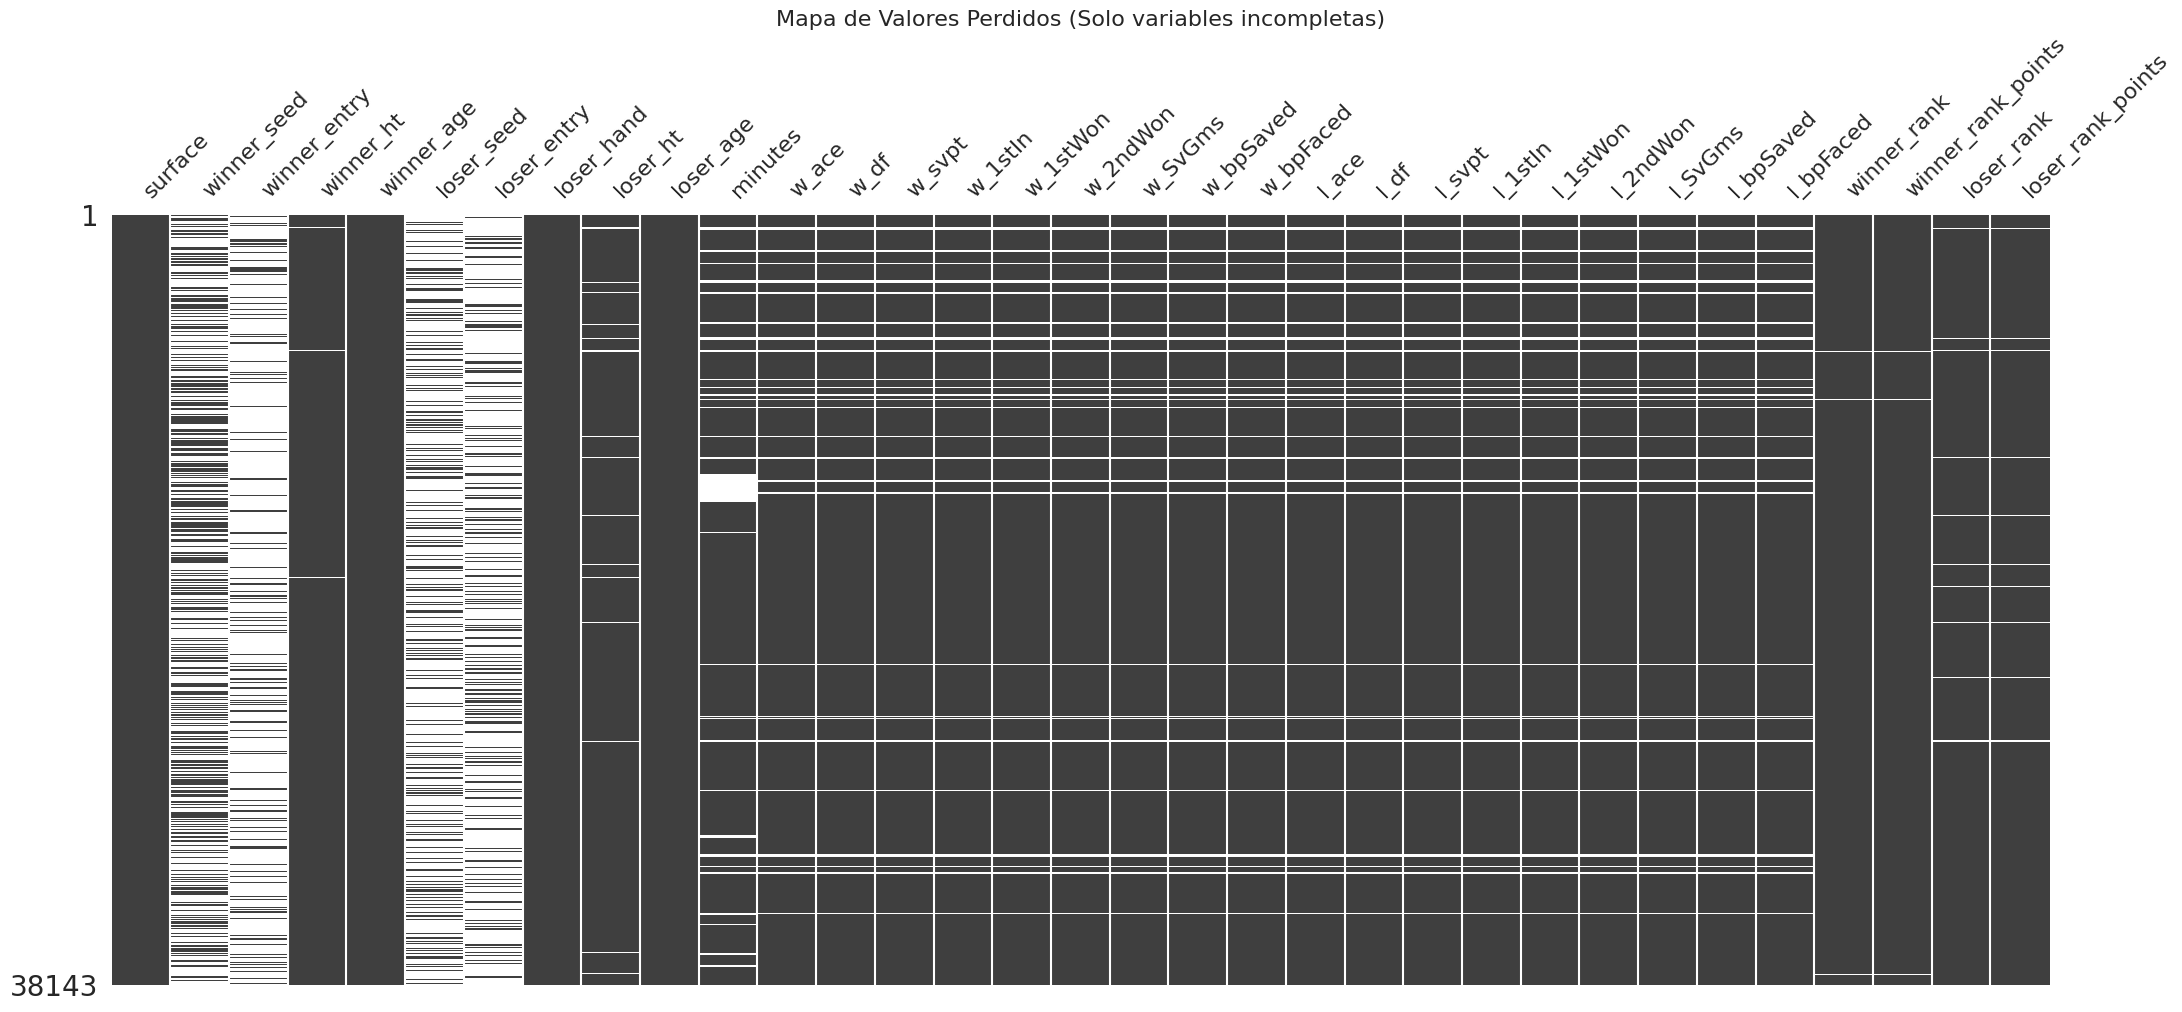

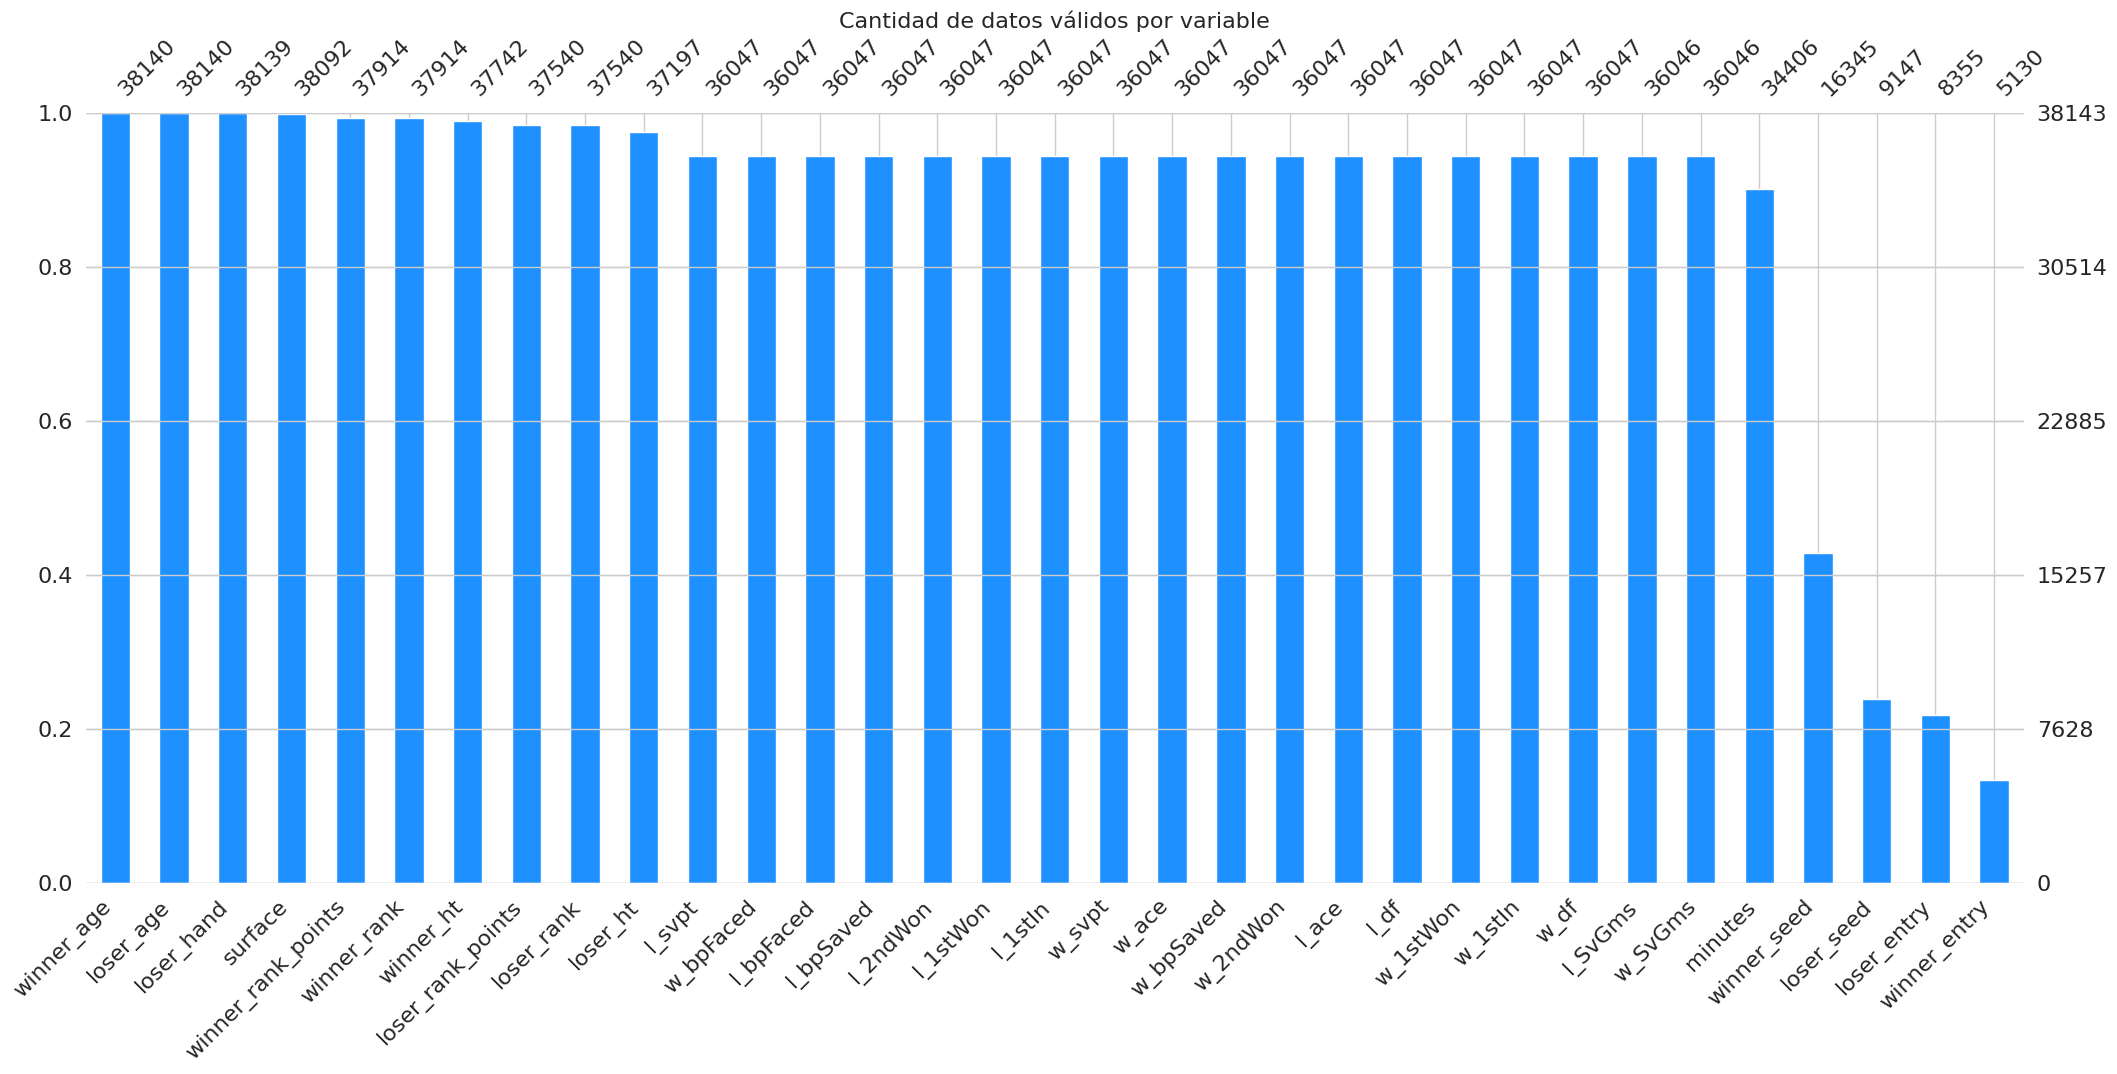

In [186]:
import missingno as msno
import matplotlib.pyplot as plt

# 1. Identificar las columnas que tienen nulos
cols_con_nulos = tennis.columns[tennis.isna().any()].tolist()

# 2. Pintar la matriz SOLO con esas columnas
# labels=True nos deja ver los nombres
msno.matrix(tennis[cols_con_nulos], labels=True, sparkline=False)
plt.title("Mapa de Valores Perdidos (Solo variables incompletas)", fontsize=16)
plt.show()

# Gráfico de barras de las variables con nulos
msno.bar(tennis[cols_con_nulos], sort='descending', color='dodgerblue')
plt.title("Cantidad de datos válidos por variable", fontsize=16)
plt.show()

No nos queda otra, que tratar cada una de las variables una por una.

### B.3-Paso 1. Edad

In [187]:
# 1. Identificar jugadores con edad faltante (Winner o Loser)
nulos_w = tennis[tennis['winner_age'].isna()]['winner_name']
nulos_l = tennis[tennis['loser_age'].isna()]['loser_name']

# Unimos las dos listas y sacamos los únicos
jugadores_sin_edad = pd.concat([nulos_w, nulos_l]).unique()

print(f"Hay {len(jugadores_sin_edad)} jugadores sin edad.")
print("Lista de jugadores para buscar en Google:")
for jugador in jugadores_sin_edad:
    print(f"- {jugador}")

Hay 4 jugadores sin edad.
Lista de jugadores para buscar en Google:
- Ari Fahresi
- Luis Carlos Alvarez Valdes
- Diego Duran
- Hamza Karmoussi



* **Ari Fahresi:** August 2, 2002 [Link](https://www.tennisexplorer.com/player/fahresi/#:~:text=Country%3A%20Indonesia,Plays%3A%20right)
* **Luis Carlos Álvarez Valdés:** September 3, 2004 [Link](https://www.atptour.com/en/players/diego-duran/d0fo/overview#:~:text=Personal%20details,(2004%2F12%2F10))
* **Diego Durán:** December 10, 2004 [Link](https://www.tennisexplorer.com/player/duran-fd3b3/#:~:text=Diego%20(2004)%20Duran%20%2D%20Tennis,Plays%3A%20right)
* **Hamza Karmoussi:** November 26, 1993 [Link](https://www.atptour.com/en/players/hamza-karmoussi/ke25/overview#:~:text=Personal%20details,(1993%2F11%2F26))

In [188]:
# --- B.3.1 CORRECCIÓN MANUAL DE EDADES (Hard-coding inteligente) ---

# Diccionario con las fechas de nacimiento reales
fechas_nacimiento = {
    'Ari Fahresi': '2002-08-02',
    'Luis Carlos Alvarez Valdes': '2004-09-03', # Note: I removed accents just in case the dataset has them plain
    'Diego Duran': '2004-12-10',                # Same here
    'Hamza Karmoussi': '1993-11-26'
}

# Bucle mágico: Calcula la edad exacta basándose en el día del partido
print("Calculando edades exactas para los jugadores sin datos...")

count = 0
for nombre, fecha_nac in fechas_nacimiento.items():
    # Convertimos la fecha de nacimiento a datetime
    dob = pd.to_datetime(fecha_nac)
    
    # 1. Corregir donde aparece como WINNER
    # Usamos 'contains' para ser flexibles con tildes (Alvarez vs Álvarez)
    mask_w = tennis['winner_name'].str.contains(nombre, case=False, regex=False)
    if mask_w.sum() > 0:
        tennis.loc[mask_w, 'winner_age'] = (tennis.loc[mask_w, 'tourney_date'] - dob).dt.days / 365.25
        count += mask_w.sum()
    
    # 2. Corregir donde aparece como LOSER
    mask_l = tennis['loser_name'].str.contains(nombre, case=False, regex=False)
    if mask_l.sum() > 0:
        tennis.loc[mask_l, 'loser_age'] = (tennis.loc[mask_l, 'tourney_date'] - dob).dt.days / 365.25
        count += mask_l.sum()

print(f"¡Éxito! Se han recuperado y calculado {count} edades exactas.")

# --- RED DE SEGURIDAD FINAL ---
# Por si acaso quedó alguno suelto (ej. un typo en el nombre), rellenamos el resto con la media.
# Esto asegura que no queden NaNs que rompan el modelo.
media_edad = pd.concat([tennis['winner_age'], tennis['loser_age']]).mean()
nulos_restantes = tennis['winner_age'].isna().sum() + tennis['loser_age'].isna().sum()

if nulos_restantes > 0:
    tennis['winner_age'] = tennis['winner_age'].fillna(media_edad)
    tennis['loser_age'] = tennis['loser_age'].fillna(media_edad)
    print(f"Aviso: Quedaban {nulos_restantes} registros sin edad. Se han rellenado con la media global ({media_edad:.2f}).")
else:
    print("Todos las edades están completas. 0 Nulos.")

Calculando edades exactas para los jugadores sin datos...
¡Éxito! Se han recuperado y calculado 6 edades exactas.
Todos las edades están completas. 0 Nulos.


---

### B.3-Paso 2. Mano.

In [189]:
# --- INSPECCIÓN DE LA MANO (HAND) ---

# 1. Buscar específicamente los NaNs (Vacíos)
filas_nulas = tennis[tennis['loser_hand'].isna()]

print(f"--- Se encontraron {len(filas_nulas)} filas con NaN en loser_hand ---")
if len(filas_nulas) > 0:
    display(filas_nulas[['tourney_date', 'loser_name', 'loser_id', 'loser_hand']])
    nombres_nan = filas_nulas['loser_name'].unique()
    print(f"\nJugadores con NaN: {nombres_nan}")

# 2. Buscar específicamente los 'U' (Unknown)
filas_unknown = tennis[tennis['loser_hand'] == 'U']
print(f"\n--- Se encontraron {len(filas_unknown)} filas con etiqueta 'U' ---")
# No los mostramos todos si son muchos, solo contamos

--- Se encontraron 4 filas con NaN en loser_hand ---


,tourney_date,loser_name,loser_id,loser_hand
11974,2015-03-06,Nour Nehme,145022,NaN
12023,2015-03-06,Maxim Bulat,145023,NaN
13188,2015-07-17,Maxim Bulat,145023,NaN
24846,2019-09-13,Sebastian Dominguez,209238,NaN



Jugadores con NaN: ['Nour Nehme' 'Maxim Bulat' 'Sebastian Dominguez']

--- Se encontraron 273 filas con etiqueta 'U' ---


Los 3 son diestros.

Aplicando correcciones manuales a los NaNs...
Nulos reales (NaN) restantes: 0

--- Estado Final de la Variable Hand ---
Valores únicos: ['R' 'L' 'U']
Total Nulos: 0


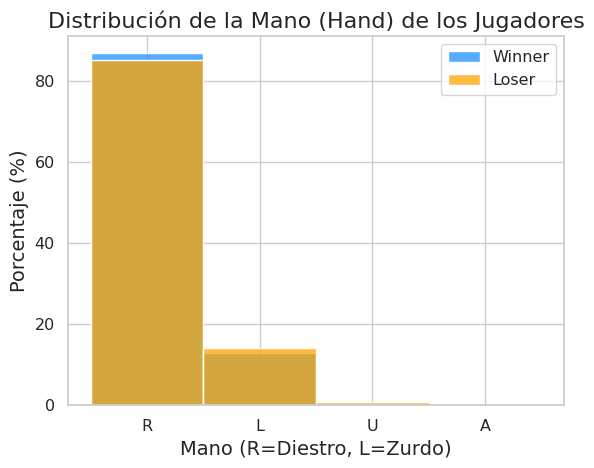

In [190]:
# --- B.3.2 SOLUCIÓN QUIRÚRGICA PARA LA MANO (HAND) ---

# 1. CORRECCIÓN MANUAL DE LOS NANS (Datos investigados)
# Diccionario con los datos reales que hemos encontrado
manos_rescatadas = {
    'Nour Nehme': 'R',
    'Maxim Bulat': 'R',
    'Sebastian Dominguez': 'R'
}

print("Aplicando correcciones manuales a los NaNs...")
for nombre, mano in manos_rescatadas.items():
    # Corregimos tanto en winner como en loser por si acaso
    tennis.loc[tennis['winner_name'] == nombre, 'winner_hand'] = mano
    tennis.loc[tennis['loser_name'] == nombre, 'loser_hand'] = mano

# Verificamos si queda algún NaN real (debería ser 0)
nulos_reales = tennis['winner_hand'].isna().sum() + tennis['loser_hand'].isna().sum()
print(f"Nulos reales (NaN) restantes: {nulos_reales}")


# 2. TRATAMIENTO DE LOS 'U' (Unknown)
# Ahora nos ocupamos de los 273 casos etiquetados como 'U'.
# Al no existir registro oficial de su mano, la opción más segura para el modelo
# es asignarlos a la clase mayoritaria (Diestro/Right), que representa el ~90% de los jugadores.

#print(f"Tratando las etiquetas 'U'...")
#tennis['winner_hand'] = tennis['winner_hand'].replace('U', 'R')
#tennis['loser_hand'] = tennis['loser_hand'].replace('U', 'R')

# 3. VERIFICACIÓN FINAL
# Ahora solo deberíamos tener 'R' y 'L' (y quizás 'A' si había alguno)
print("\n--- Estado Final de la Variable Hand ---")
print(f"Valores únicos: {tennis['loser_hand'].unique()}")
print(f"Total Nulos: {tennis[['winner_hand', 'loser_hand']].isna().sum().sum()}")

sns.histplot(tennis['winner_hand'], color='dodgerblue', label='Winner', kde=False, stat='percent', discrete=True)
sns.histplot(tennis['loser_hand'], color='orange', label='Loser', kde=False, stat='percent', discrete=True)
plt.title("Distribución de la Mano (Hand) de los Jugadores", fontsize=16)
plt.xlabel("Mano (R=Diestro, L=Zurdo)", fontsize=14)
plt.ylabel("Porcentaje (%)", fontsize=14)
plt.legend()
plt.show()

mirar pero hay que tratar U

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Tiempo total de ejecución

In [191]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:00:02.405716
